# Setting Up Working Environment

In [1]:
# Create the Conda environment
!conda create -n jpereira_wfs_task python=3.11 -y
!conda install -n jpereira_wfs_task ipykernel -y

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\fuji_\anaconda3\envs\jpereira_wfs_task

  added / updated specs:
    - python=3.11


The following NEW packages will be INSTALLED:

  bzip2              pkgs/main/win-64::bzip2-1.0.8-h2bbff1b_6 
  ca-certificates    pkgs/main/win-64::ca-certificates-2024.7.2-haa95532_0 
  libffi             pkgs/main/win-64::libffi-3.4.4-hd77b12b_1 
  openssl            pkgs/main/win-64::openssl-3.0.15-h827c3e9_0 
  pip                pkgs/main/win-64::pip-24.2-py311haa95532_0 
  python             pkgs/main/win-64::python-3.11.9-he1021f5_0 
  setuptools         pkgs/main/win-64::setuptools-75.1.0-py311haa95532_0 
  sqlite             pkgs/main/win-64::sqlite-3.45.3-h2bbff1b_0 
  tk                 pkgs/main/win-64::tk-8.6.14-h0416ee5_0 
  tzdata             pkgs/main/noarch::tzdata-2024a-h04d1e81_0 
  vc                 pkgs/main/win-64::vc-14.40-h2eaa2aa_1 
  vs2015_run

In [3]:
import sys
!{sys.executable} -m pip install uv 
!uv pip install geospatial

  Using cached uv-0.4.17-py3-none-win_amd64.whl.metadata (11 kB)
Using cached uv-0.4.17-py3-none-win_amd64.whl (13.4 MB)


Resolved 412 packages in 1.90s
Prepared 2 packages in 131ms
Uninstalled 3 packages in 481ms
Installed 385 packages in 23.04s
 + access==1.1.9
 + aenum==3.1.15
 + affine==2.4.0
 + aiobotocore==2.15.1
 + aiohappyeyeballs==2.4.2
 + aiohttp==3.10.8
 + aioitertools==0.12.0
 + aiosignal==1.3.1
 + aniso8601==9.0.1
 + annotated-types==0.7.0
 + anyio==4.6.0
 + anywidget==0.9.13
 + apache-sedona==1.6.1
 + appdirs==1.4.4
 + argon2-cffi==23.1.0
 + argon2-cffi-bindings==21.2.0
 + arrow==1.3.0
 + asciitree==0.3.3
 + asgiref==3.8.1
 + async-lru==2.0.4
 + attrs==24.2.0
 + azure-core==1.31.0
 + azure-storage-blob==12.23.1
 + azure-storage-file-datalake==12.17.0
 + babel==2.16.0
 + beautifulsoup4==4.12.3
 + bleach==6.1.0
 + blinker==1.8.2
 + bokeh==3.6.0
 + boto3==1.35.23
 + botocore==1.35.23
 + bounded-pool-executor==0.0.3
 + bqplot==0.12.43
 + branca==0.8.0
 + cachelib==0.9.0
 + cachetools==5.5.0
 + cenpy==1.0.1
 + certifi==2024.8.30
 + cffi==1.17.1
 + cftime==1.6.4
 + charset-normalizer==3.3.2
 + chr

# Package Imports 

In [2]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import os
import rioxarray
import geopandas as gpd
import xarray as xr

# Task 1

In [4]:
# Find all TIFF files and create a raster list

raster_dir = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_01\NDVI"

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

Total number of TIFF files: 5


['C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_01\\NDVI\\2023-03-03_09-57-06.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_01\\NDVI\\2023-05-22_09-57-09.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_01\\NDVI\\2023-08-15_09-57-10.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_01\\NDVI\\2023-10-02_10-07-02.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_01\\NDVI\\brno_mean_ndvi_2023.tiff']

In [6]:
def stack_rasters(tiff_files, output_tiff, aoi_shapefile=None, chunk_size=None, operation=None):
    """
    Clips, stacks a list of raster files based on an AOI shapefile, calculates the sum, median, or mean of the stack,
    and saves the resulting raster to a file. Processes data in chunks to reduce memory usage.

    :param tiff_files: List of paths to the input TIFF files
    :param aoi_shapefile: Path to the AOI shapefile (optional, default is None)
    :param output_tiff: Path for the output raster file
    :param operation: Operation to perform on the stack ('mean')
    :param chunk_size: Size of chunks for processing (e.g., (500, 500))
    :return: None
    """
    if aoi_shapefile:
        aoi = gpd.read_file(aoi_shapefile)

        # Extract the first geometry from the AOI and put it in a list
        polygon_geometry = [aoi.geometry.iloc[0]]
    else:
        polygon_geometry = None

    raster_arrays = []
    no_data_values = []

    for tiff in tiff_files:
        raster = rioxarray.open_rasterio(tiff, chunks=chunk_size)

        # Store the NoData value for the current raster
        no_data = raster.rio.nodata
        no_data_values.append(no_data)

        if polygon_geometry:
            # Clip the raster using the AOI geometry
            clipped_raster = raster.rio.clip(polygon_geometry, aoi.crs, drop=True, invert=False)
            # Use np.nan for NoData
            clipped_raster = clipped_raster.where(clipped_raster != no_data, other=np.nan)  
            raster_arrays.append(clipped_raster)
        else:
            raster_arrays.append(raster.where(raster != no_data, other=np.nan))  

    stacked_rasters = xr.concat(raster_arrays, dim='band')

    # Perform the specified operation across the 'band' dimension
    if operation == 'mean':
        # Exclude NoData pixels (np.nan) from the mean calculation
        result_raster = stacked_rasters.where(~np.isnan(stacked_rasters)).mean(dim='band')
    else:
        raise ValueError("Invalid operation. Choose 'mean'")

    # Set the CRS of the result raster to match the AOI shapefile's CRS if AOI provided
    if aoi_shapefile:
        result_raster.rio.write_crs(aoi.crs, inplace=True)

    # Set the NoData value for the result raster to the NoData of the first raster
    result_no_data_value = no_data_values[0]  # Assuming all rasters have the same NoData value
    result_raster.rio.write_nodata(result_no_data_value, inplace=True)

    # Write the result raster to a new file
    result_raster.rio.to_raster(output_tiff)

In [27]:
tiff_files = input_tiffs
output_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_01\NDVI\brno_mean_ndvi_2023.tiff"
aoi_shapefile = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_01\Brno_boundaries\Brno_boundaries.shp"

In [8]:
stack_rasters(tiff_files, output_tiff, aoi_shapefile=aoi_shapefile, chunk_size=None, operation='mean')

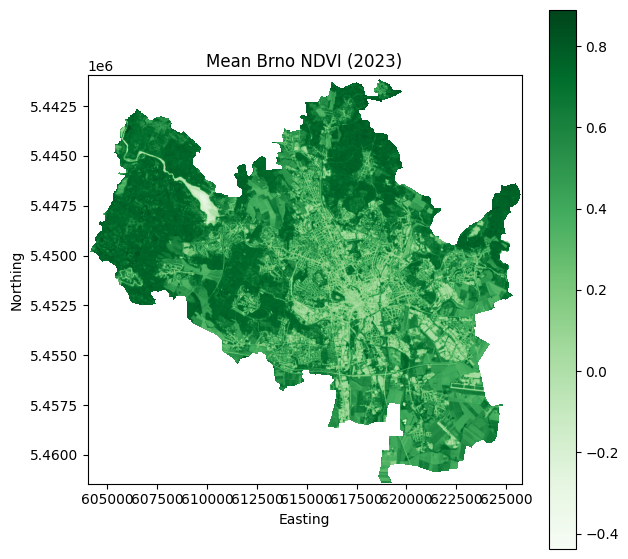

In [31]:
# Open the NDVI mean raster file

with rasterio.open(output_tiff) as src:
    # Read the NDVI data as a NumPy array
    evi_data = src.read(1)  # Assuming EVI is in the first band (band index 1)

    # Get the No Data value from the raster metadata
    no_data_value = src.nodata

    # Mask the No Data values for visualization
    masked_data = np.ma.masked_where(evi_data == no_data_value, evi_data)

    # Get the affine transformation (transform) from the raster to compute extent
    transform = src.transform

    # Extract the extent using the transform
    x_min, y_min = transform * (0, 0)  # Bottom-left corner
    x_max, y_max = transform * (src.width, src.height)  # Top-right corner

    # Visualize the EVI data considering the masked data
    plt.figure(figsize=(7, 7))
    plt.imshow(masked_data, cmap='Greens', extent=(x_min, x_max, y_min, y_max))
    plt.colorbar()
    plt.title('Mean Brno NDVI (2023)')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.show()

# Task 2

In [9]:
raster_dir = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI"

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

Total number of TIFF files: 5


['C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_02\\EVI\\vraz_corn_2020-08-21_EVI.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_02\\EVI\\vraz_corn_2022-07-17_EVI.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_02\\EVI\\vraz_wheat_2018-05-26_EVI.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_02\\EVI\\vraz_wheat_2019-06-03_EVI.tiff',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\world-from-space\\gis_star_task_02\\EVI\\vraz_wheat_2021-06-04_EVI.tiff']

In [10]:
def process_raster(input_raster, n_clusters=5):
    """Processes a single raster file and applies K-means clustering."""
    
    # Open the raster file using rasterio
    with rasterio.open(input_raster) as src:
        raster_data = src.read(1)  # Read the first band (for single-band raster)
        raster_meta = src.meta     # Get metadata (used for saving output later)
        nodata_value = src.nodata

    # Step 2: Prepare the data (flatten the 2D raster into a 1D array)
    raster_flat = raster_data.flatten()  # Convert 2D array to 1D
    raster_valid = raster_flat[raster_flat != nodata_value]  # Remove NoData values

    # Step 3: Apply K-means clustering
    raster_valid = raster_valid.reshape(-1, 1)  # Reshape to 2D (required by KMeans)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(raster_valid)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Step 4: Reassign cluster labels to the original raster shape
    clustered_raster = np.full_like(raster_flat, fill_value=nodata_value)
    clustered_raster[raster_flat != nodata_value] = cluster_labels + 1  # Add 1 for non-zero labels
    clustered_raster = clustered_raster.reshape(raster_data.shape)

    return clustered_raster, raster_meta

def relabel_clusters(clustered_raster, raster_flat, nodata_value):
    """Relabels the clusters based on their minimum values."""
    
    # Calculate the range of values for each cluster
    cluster_ranges = defaultdict(list)
    cluster_labels_flat = clustered_raster.flatten()

    for pixel_value, cluster_label in zip(raster_flat, cluster_labels_flat):
        if pixel_value != nodata_value:  # Ignore NoData values
            cluster_ranges[cluster_label].append(pixel_value)

    cluster_info = []
    for cluster, values in cluster_ranges.items():
        min_val = np.min(values)
        max_val = np.max(values)
        count = len(values)
        cluster_info.append((cluster, min_val, max_val, count))

    # Sort clusters by minimum value
    for i in range(len(cluster_info)):
        for j in range(len(cluster_info) - 1 - i):
            if cluster_info[j][1] > cluster_info[j + 1][1]:
                cluster_info[j], cluster_info[j + 1] = cluster_info[j + 1], cluster_info[j]

    # Create a new mapping based on the sorted order
    new_labels = {cluster_info[i][0]: i + 1 for i in range(len(cluster_info))}

    # Create a copy of the clustered raster for relabeling
    relabelled_raster = np.copy(clustered_raster)

    # Apply the new labels
    for old_label, new_label in new_labels.items():
        relabelled_raster[clustered_raster == old_label] = new_label

    return relabelled_raster

def save_raster(output_raster, data, meta):
    """Saves the raster data to a new file."""
    with rasterio.open(output_raster, 'w', **meta) as dst:
        dst.write(data, 1)  # Write the data as the first band

def process_directory(input_directory, output_directory, n_clusters=5):
    """Processes all TIFF files in a directory."""
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Iterate over each TIFF file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            input_raster = os.path.join(input_directory, filename)
            print(f"Processing {input_raster}")

            # Process the raster
            clustered_raster, raster_meta = process_raster(input_raster, n_clusters)

            # Relabel the clusters
            relabelled_raster = relabel_clusters(clustered_raster, clustered_raster.flatten(), raster_meta['nodata'])

            # Save the relabelled raster
            new_output_raster = os.path.join(output_directory, filename.replace('.tiff', '_relabelled.tiff'))
            save_raster(new_output_raster, relabelled_raster, raster_meta)
            print(f"Relabeling output saved at {new_output_raster}")

In [11]:
input_directory = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI"
output_directory = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output"

process_directory(input_directory, output_directory)

Processing C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\vraz_corn_2020-08-21_EVI.tiff...
Relabeling output saved at C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output\vraz_corn_2020-08-21_EVI_relabelled.tiff
Processing C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\vraz_corn_2022-07-17_EVI.tiff...
Relabeling output saved at C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output\vraz_corn_2022-07-17_EVI_relabelled.tiff
Processing C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\vraz_wheat_2018-05-26_EVI.tiff...
Relabeling output saved at C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output\vraz_wheat_2018-05-26_EVI_relabelled.tiff
Processing C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\vraz_wheat_2019-06-03_EVI.tiff...
Relabeling output saved at C:\Users\fuji_\Desktop\Geospat

In [12]:
# Calculate Average (mean) of all the rasters

In [13]:
raster_dir = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output"

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

output_tiff_mean = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output\vraz_evi_kmeans_mean.tiff"


Total number of TIFF files: 5


In [14]:
stack_rasters(input_tiffs, output_tiff_mean, aoi_shapefile=None, chunk_size=None, operation='mean')

In [21]:
def convert_raster_to_integers(input_tiff, output_tiff):
    """
    Converts raster values to integers and saves the output, preserving native NoData values.

    :param input_tiff: Path for the input raster file
    :param output_tiff: Path for the output raster file
    :return: None
    """
    # Open the raster file using rioxarray
    raster = rioxarray.open_rasterio(input_tiff)

    # Get the native NoData value
    nodata_value = raster.rio.nodata

    # Round values to nearest integers
    float_raster = raster.round()

    # Preserve native NoData values
    int_raster = float_raster.where(float_raster != nodata_value, other=np.nan)

    # Convert to int32, ensuring NoData remains as np.nan
    int_raster = int_raster.where(~np.isnan(int_raster), other=np.nan).astype(np.float32)  # Use float to keep np.nan

    # Write the native NoData value to the raster metadata
    int_raster.rio.write_nodata(nodata_value, inplace=True)

    # Save the converted raster to a new file
    int_raster.rio.to_raster(output_tiff)


In [22]:
output_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\world-from-space\gis_star_task_02\EVI\output\vraz_evi_kmeans_mean_integer.tiff"
convert_raster_to_integers(output_tiff_mean, output_tiff)

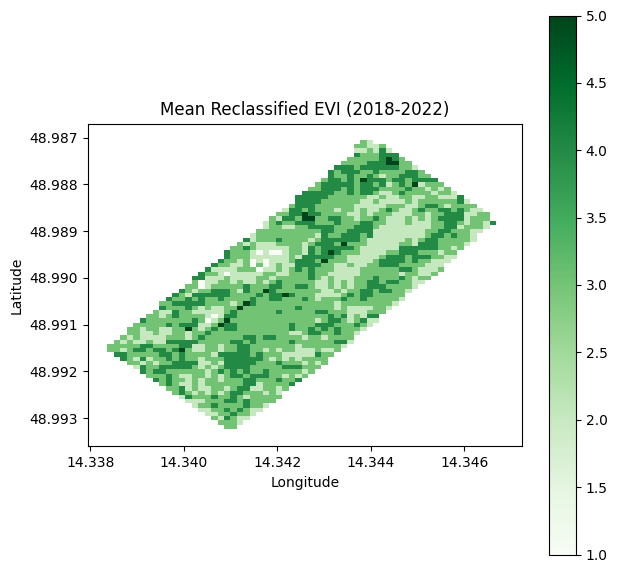

In [23]:
# Open the EVI raster file
with rasterio.open(output_tiff) as src:
    # Read the EVI data as a NumPy array
    evi_data = src.read(1)  # Assuming EVI is in the first band (band index 1)

    # Get the No Data value from the raster metadata
    no_data_value = src.nodata

    # Mask the No Data values for visualization
    masked_data = np.ma.masked_where(evi_data == no_data_value, evi_data)

    # Get the affine transformation (transform) from the raster to compute extent
    transform = src.transform

    # Extract the extent using the transform
    x_min, y_min = transform * (0, 0)  # Bottom-left corner
    x_max, y_max = transform * (src.width, src.height)  # Top-right corner

    # Visualize the EVI data considering the masked data
    plt.figure(figsize=(7, 7))
    plt.imshow(masked_data, cmap='Greens', extent=(x_min, x_max, y_min, y_max))  # Add extent here
    plt.colorbar()
    plt.title('Mean Reclassified EVI (2018-2022)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()